In [1]:
# Loading required libraries and functions
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from keras.applications import imagenet_utils
from keras import backend
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [2]:
# Paths to the data directories
train_path = r'D:\MAIN\Universitas Udayana\Belajar\SEMESTER 5 MBKM\BANGKIT MACHINE LEARNING\Capstone Project\Dataset Final diedit\DatasetFInal\train'
valid_path = r'D:\MAIN\Universitas Udayana\Belajar\SEMESTER 5 MBKM\BANGKIT MACHINE LEARNING\Capstone Project\Dataset Final diedit\DatasetFInal\validation'
test_path = r'D:\MAIN\Universitas Udayana\Belajar\SEMESTER 5 MBKM\BANGKIT MACHINE LEARNING\Capstone Project\Dataset Final diedit\DatasetFInal\test'

# Function to count images in a directory
def count_images_in_directory(directory):
    count = sum(len(files) for _, _, files in os.walk(directory))
    return count

# Count the number of images in each directory
train_count = count_images_in_directory(train_path)
valid_count = count_images_in_directory(valid_path)
test_count = count_images_in_directory(test_path)

# Print the counts
print("Train Data:", train_count)
print("Valid Data:", valid_count)
print("Test Data:", test_count)

Train Data: 16921
Valid Data: 4665
Test Data: 2280


In [3]:
# Create data generators with preprocessing_function
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical'
)

valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical'
)

#est_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
#directory=test_path, target_size=(224, 224), batch_size=20, shuffle=False)

test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
    ).flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        shuffle=False)

# Get the number of samples in each dataset
train_samples = train_batches.samples
valid_samples = valid_batches.samples
test_samples = test_batches.samples

Found 16912 images belonging to 22 classes.
Found 4665 images belonging to 22 classes.
Found 2280 images belonging to 22 classes.


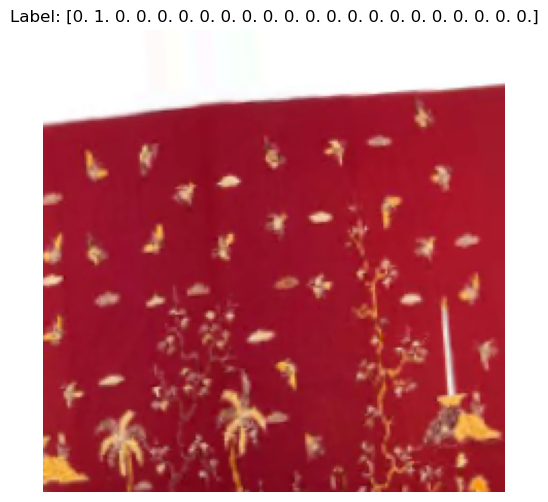

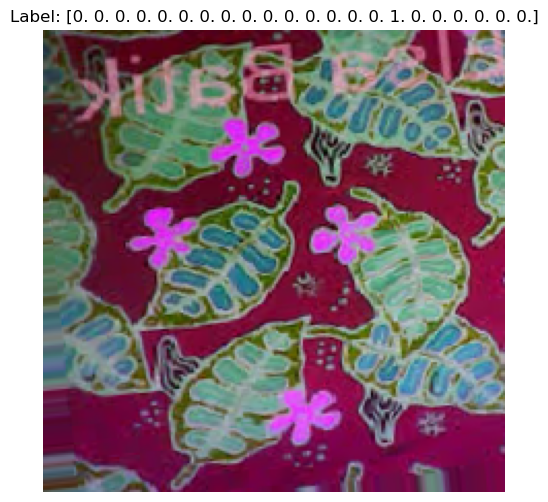

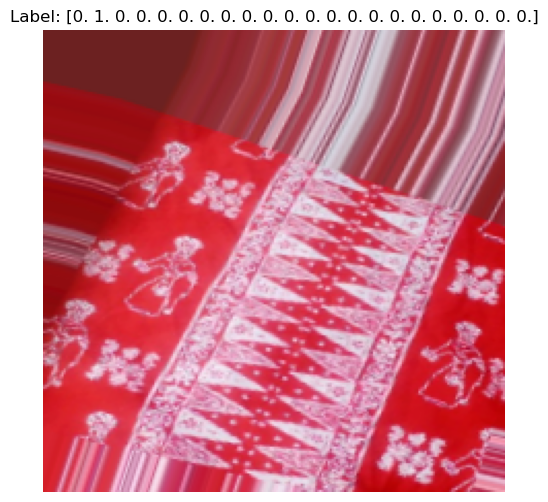

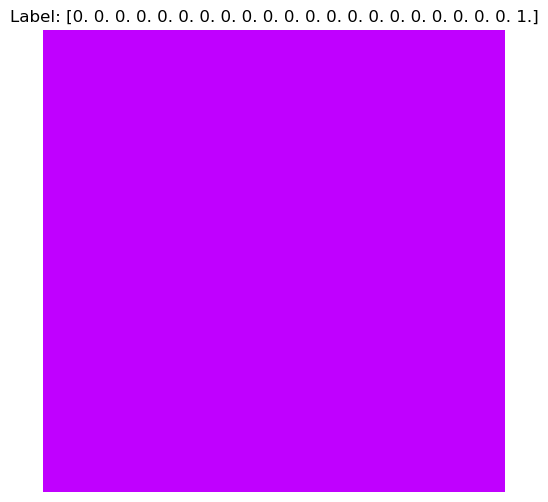

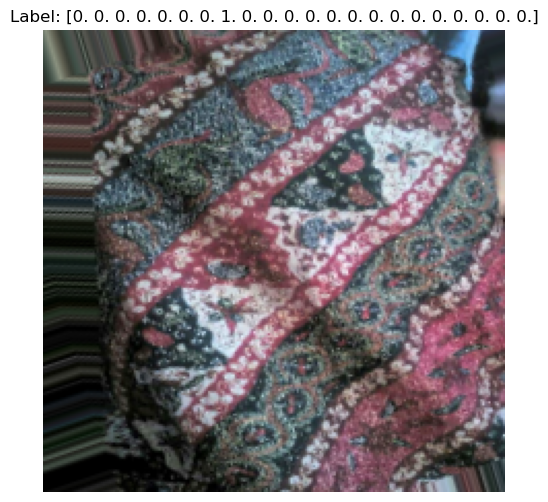

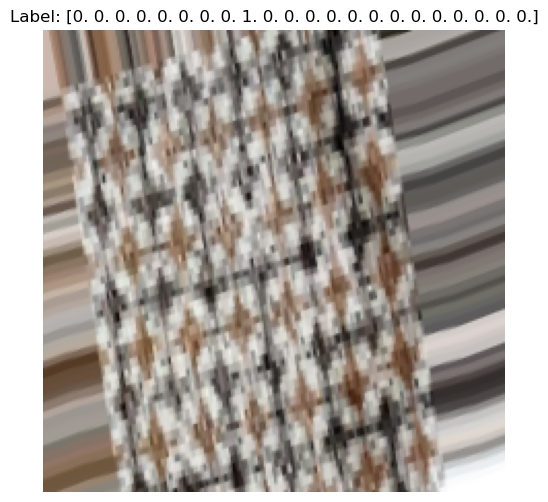

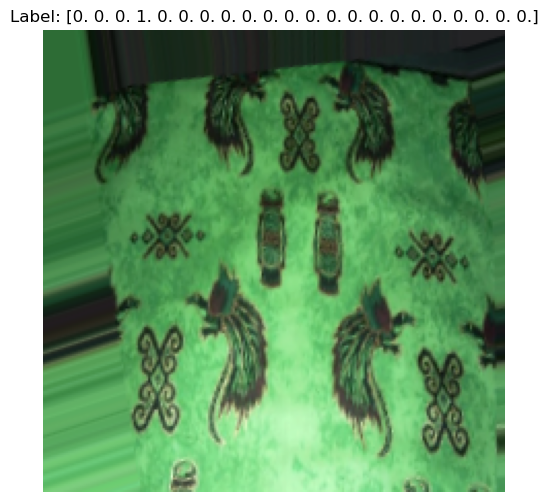

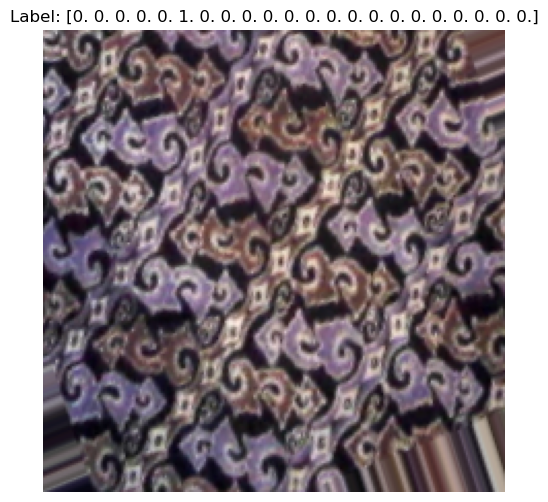

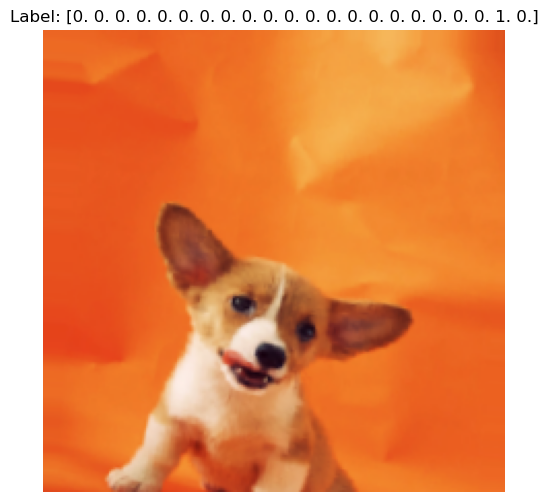

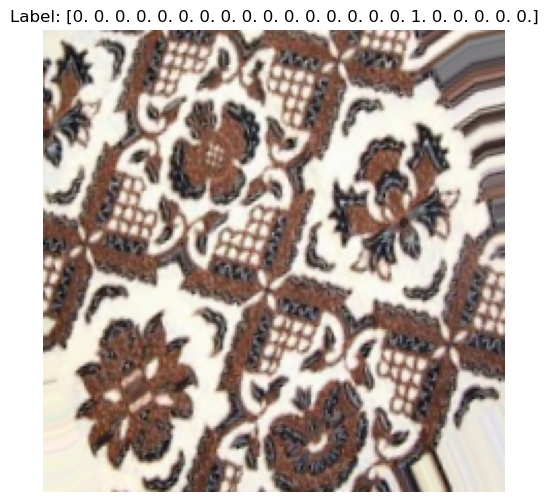

In [4]:
# Pilih satu batch dari generator data
sample_batch = next(train_batches)

# Ambil beberapa contoh citra dari batch
sample_images = sample_batch[0][:10]  # Ambil 4 citra pertama dari batch
sample_labels = sample_batch[1][:10]  # Ambil label untuk 4 citra pertama

# Loop melalui citra dan tampilkan setiap citra setelah augmentasi
for i in range(len(sample_images)):
    img = image.array_to_img(sample_images[i])
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Label: {sample_labels[i]}")  # Menampilkan label citra
    plt.axis('off')  # Tidak menampilkan sumbu
    plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)  # Ganti `2` dengan jumlah kelas pada tugas Anda

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Define custom confidence metric
def confidence(y_true, y_pred):
    return tf.reduce_max(y_pred, axis=-1)

# Compile the model with a specific learning rate and the custom confidence metric
learning_rate = 0.001  # Ubah nilai ini sesuai kebutuhan Anda
optimizer = optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', confidence])

# Define callback
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [6]:
# Train the model with EarlyStopping
history = model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    verbose=2,
#     callbacks=[early_stopping]
)

Epoch 1/20
846/846 - 557s - loss: 1.2971 - accuracy: 0.6089 - confidence: 0.5944 - val_loss: 0.7002 - val_accuracy: 0.7856 - val_confidence: 0.7618 - 557s/epoch - 659ms/step
Epoch 2/20
846/846 - 371s - loss: 0.6692 - accuracy: 0.7899 - confidence: 0.7633 - val_loss: 0.4776 - val_accuracy: 0.8568 - val_confidence: 0.8231 - 371s/epoch - 438ms/step
Epoch 3/20
846/846 - 355s - loss: 0.4676 - accuracy: 0.8544 - confidence: 0.8291 - val_loss: 0.3809 - val_accuracy: 0.8855 - val_confidence: 0.8671 - 355s/epoch - 420ms/step
Epoch 4/20
846/846 - 469s - loss: 0.3654 - accuracy: 0.8838 - confidence: 0.8659 - val_loss: 0.3320 - val_accuracy: 0.9029 - val_confidence: 0.8948 - 469s/epoch - 554ms/step
Epoch 5/20
846/846 - 593s - loss: 0.2932 - accuracy: 0.9079 - confidence: 0.8921 - val_loss: 0.2977 - val_accuracy: 0.9181 - val_confidence: 0.9106 - 593s/epoch - 701ms/step
Epoch 6/20
846/846 - 471s - loss: 0.2570 - accuracy: 0.9185 - confidence: 0.9097 - val_loss: 0.2946 - val_accuracy: 0.9183 - val_c

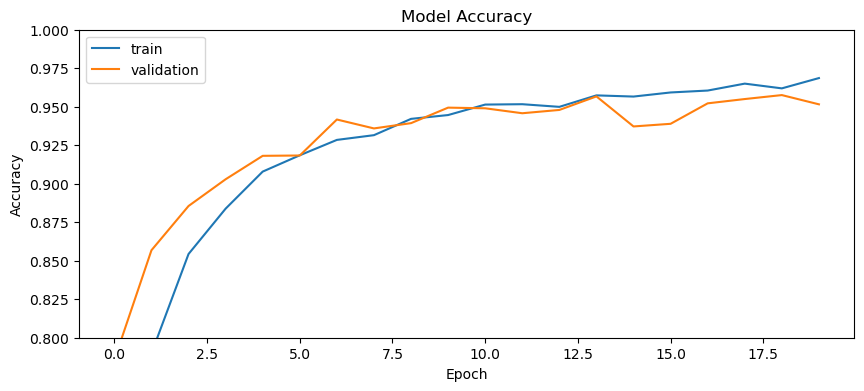

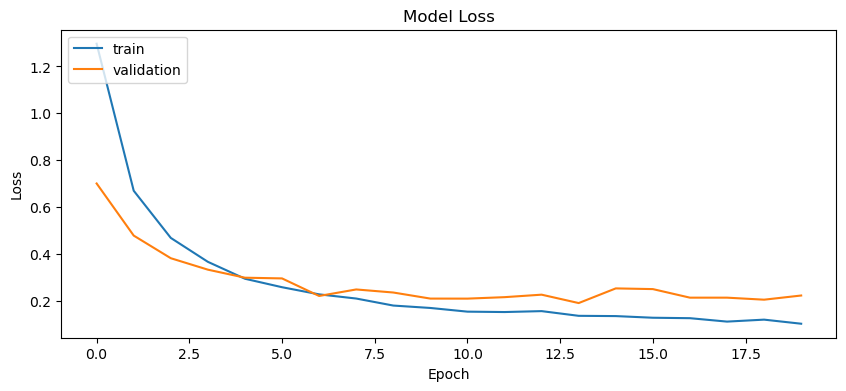

In [7]:
# summarize history for accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.8, 1])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
import datetime

# Generate timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Path to save the model
save_path = r'D:\MAIN\Universitas Udayana\Belajar\SEMESTER 5 MBKM\BANGKIT MACHINE LEARNING\Capstone Project\Dataset Final diedit\hasil\hasilbaru5.h5'

# Save the model
model.save(save_path)
print("Model saved successfully.")

Model saved successfully.


In [10]:
# Import libraries
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score

# Make predictions and plot confusion matrix to evaluate model performance
start_time = time.time()

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average=None)
f1 = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average=None)
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average=None)
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
end_time = time.time()
elapsed_time = end_time - start_time

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

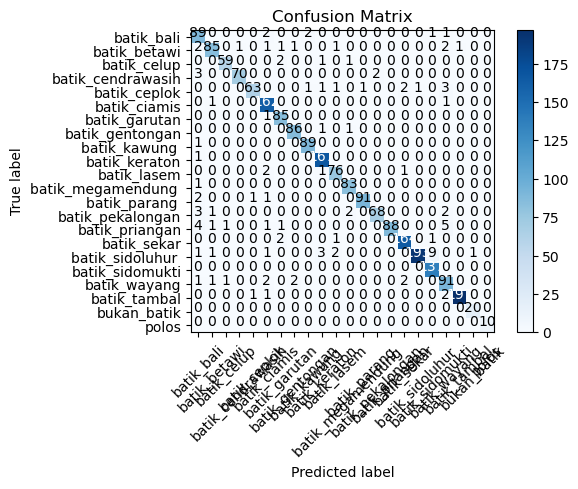

In [11]:
# Confusion Matrix
test_batches.class_indices
cm_plot_labels = ['batik_bali', 'batik_betawi', 'batik_celup', 'batik_cendrawasih', 'batik_ceplok', 'batik_ciamis', 'batik_garutan', 'batik_gentongan', 'batik_kawung ','batik_keraton', 'batik_lasem', 'batik_megamendung ', 'batik_parang ', 'batik_pekalongan', 'batik_priangan', 'batik_sekar', 'batik_sidoluhur ', 'batik_sidomukti', 'batik_wayang', 'batik_tambal','bukan_batik','polos']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [12]:
import numpy as np

import keras.utils as image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [14]:
import tensorflow as tf
import numpy as np
# import cv2
# from google.colab import files
from IPython.display import Image

# Define custom confidence metric
def confidence(y_true, y_pred):
    return tf.reduce_max(y_pred, axis=-1)

# Load model with custom_objects to include the custom metric
model = tf.keras.models.load_model(r'D:\MAIN\Universitas Udayana\Belajar\SEMESTER 5 MBKM\BANGKIT MACHINE LEARNING\Capstone Project\Dataset Final diedit\hasil\FINAL\Model_ML_Batik_5.0.h5', custom_objects={'confidence': confidence})

# Fungsi untuk membaca gambar dan preprocessing
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk memprediksi kelas dan confidence score
def predict_class(image_path):
    img = load_and_preprocess_image(image_path)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    class_name = "flood" if class_idx == 0 else "non-flood"
    confidence_score = pred[0][class_idx]
    return class_name, confidence_score

In [15]:
# Pring precision, F1 score and accuracy of our model
print('Precision: ', precision)
print("Recall:", recall)
print('F1 Score: ', f1)
print('Accuracy: ', accuracy)
print("Computing Time:", elapsed_time, "s")

Precision:  [0.82407407 0.94444444 0.96721311 0.98591549 0.96923077 0.93103448
 0.93406593 0.96629213 0.9673913  0.95977011 0.9382716  0.95402299
 0.98913043 0.97142857 1.         0.9704142  0.99484536 0.92567568
 0.85046729 0.99494949 0.95238095 1.        ]
Recall: [0.93684211 0.89473684 0.93650794 0.93333333 0.8630137  0.98780488
 0.98837209 0.97727273 0.98888889 0.99404762 0.95       0.98809524
 0.95789474 0.89473684 0.87128713 0.97619048 0.91469194 1.
 0.91       0.9800995  1.         1.        ]
F1 Score:  [0.87684729 0.91891892 0.9516129  0.95890411 0.91304348 0.95857988
 0.96045198 0.97175141 0.97802198 0.97660819 0.94409938 0.97076023
 0.97326203 0.93150685 0.93121693 0.97329377 0.95308642 0.96140351
 0.87922705 0.98746867 0.97560976 1.        ]
Accuracy:  0.9530701754385965
Computing Time: 45.10248136520386 s


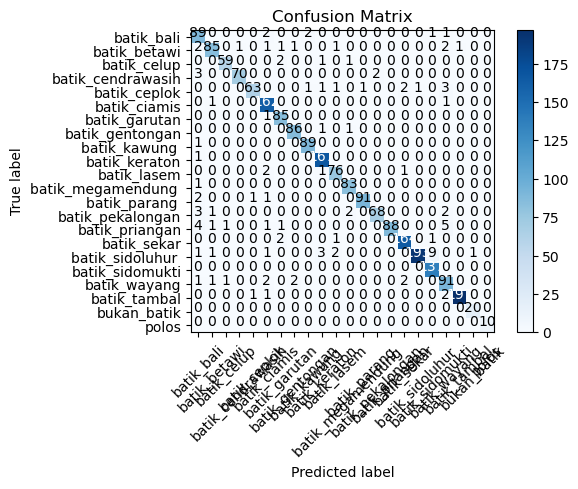

In [16]:
# Confusion Matrix
test_batches.class_indices
cm_plot_labels = ['batik_bali', 'batik_betawi', 'batik_celup', 'batik_cendrawasih', 'batik_ceplok', 'batik_ciamis', 'batik_garutan', 'batik_gentongan', 'batik_kawung ','batik_keraton', 'batik_lasem', 'batik_megamendung ', 'batik_parang ', 'batik_pekalongan', 'batik_priangan', 'batik_sekar', 'batik_sidoluhur ', 'batik_sidomukti', 'batik_wayang', 'batik_tambal','bukan_batik','polos']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
